In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import math
import env
import acquire
import prepare
import summarize

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/iris_db'
query = '''
SELECT * FROM measurements JOIN species USING(species_id);
'''

# Modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D
iris = pd.read_sql(query, url)

#### Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

###### Be sure to do the correct join. We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid
###### only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property id's), along with zestimate error and date of transaction.
##### only include properties that include a latitude and longitude value

In [8]:
df=acquire.get_zillow_data()
df=pd.DataFrame(df)

In [9]:
summarize.df_summary(df)

--- Shape: (77381, 62)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 62 columns):
parcelid                        77381 non-null int64
logerror                        77381 non-null float64
transactiondate                 77381 non-null object
id                              77381 non-null int64
parcelid                        77381 non-null int64
airconditioningtypeid           24953 non-null float64
architecturalstyletypeid        206 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77381 non-null float64
bedroomcnt                      77381 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49672 non-null float64
calculatedbathnbr               76772 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6023 non-null float64
calculatedfinishedsquarefeet    77185 non-null float

   num_cols_missing    pct_cols_missing  num_rows
0                19   30.64516129032258         2
1                20   32.25806451612903        10
2                21   33.87096774193548        83
3                22  35.483870967741936       262
4                23  37.096774193548384       599
5                24   38.70967741935484       660
6                25   40.32258064516129      5768
7                26  41.935483870967744      7996
8                27   43.54838709677419     12410
9                28   45.16129032258064     20660
10               29  46.774193548387096     16098
11               30   48.38709677419355      6391
12               31                50.0      3604
13               32   51.61290322580645      2089
14               33    53.2258064516129       300
15               34   54.83870967741935       230
16               35  56.451612903225815        29
17               36   58.06451612903226        23
18               37   59.67741935483871        28


AttributeError: 'DataFrame' object has no attribute 'dtype'

summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 62 columns):
parcelid                        77381 non-null int64
logerror                        77381 non-null float64
transactiondate                 77381 non-null object
id                              77381 non-null int64
parcelid                        77381 non-null int64
airconditioningtypeid           24953 non-null float64
architecturalstyletypeid        206 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77381 non-null float64
bedroomcnt                      77381 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49672 non-null float64
calculatedbathnbr               76772 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6023 non-null float64
calculatedfinishedsquarefeet    77185 non-null float64
finishedsquarefeet12         

In [11]:
df.shape


(77381, 62)

In [12]:
df.dtypes

parcelid                          int64
logerror                        float64
transactiondate                  object
id                                int64
parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64


In [13]:
df.describe()

,parcelid,logerror,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,7.738100e+04,77381.000000,7.738100e+04,7.738100e+04,24953.000000,206.000000,50.000000,77381.000000,77381.000000,15.000000,...,77118.000000,17560.000000,172.0,7.726900e+04,7.738000e+04,77381.0,7.737900e+04,77376.000000,2886.000000,7.713700e+04
mean,1.300715e+07,0.016625,1.495139e+06,1.300715e+07,1.813289,7.388350,679.720000,2.299130,3.053489,3.933333,...,1968.635831,1.434738,1.0,1.893145e+05,4.901345e+05,2016.0,3.010954e+05,5995.532346,14.087318,6.049673e+13
std,3.481346e+06,0.170191,8.609071e+05,3.481346e+06,2.967894,2.734542,689.703546,0.996651,1.139096,0.258199,...,23.786032,0.544569,0.0,2.300874e+05,6.534440e+05,0.0,4.925960e+05,7622.844153,2.185663,1.535242e+12
min,1.071186e+07,-4.655420,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,...,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13
25%,1.153830e+07,-0.024377,7.520700e+05,1.153830e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,...,1953.000000,1.000000,1.0,8.426500e+04,2.070000e+05,2016.0,8.550400e+04,2715.632500,14.000000,6.037311e+13
50%,1.253157e+07,0.006627,1.497932e+06,1.253157e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,...,1970.000000,1.000000,1.0,1.364990e+05,3.589755e+05,2016.0,2.033720e+05,4450.695000,15.000000,6.037603e+13
75%,1.421183e+07,0.039203,2.240535e+06,1.421183e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,...,1987.000000,2.000000,1.0,2.187870e+05,5.690015e+05,2016.0,3.667965e+05,6927.790000,15.000000,6.059042e+13
max,1.676893e+08,5.262999,2.982274e+06,1.676893e+08,13.000000,21.000000,3560.000000,18.000000,16.000000,4.000000,...,2016.000000,6.000000,1.0,1.142179e+07,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14


In [14]:
pd.DataFrame(df.columns)

,0
0,parcelid
1,logerror
2,transactiondate
3,id
4,parcelid
5,airconditioningtypeid
6,architecturalstyletypeid
7,basementsqft
8,bathroomcnt
9,bedroomcnt


In [15]:
df.shape

(77381, 62)

In [16]:
numbers_missing=df.isnull().sum()

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [17]:
missing = (df.isnull().sum())/df.shape[0]

In [18]:
summarize.nulls_by_col(df)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
logerror,0,0.000000
transactiondate,0,0.000000
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52428,0.677531
architecturalstyletypeid,77175,0.997338
basementsqft,77331,0.999354
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000


In [19]:

pct_missing = (df.isnull().sum())/df.shape[0]

In [20]:
pct_missing

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
id                              0.000000
parcelid                        0.000000
airconditioningtypeid           0.677531
architecturalstyletypeid        0.997338
basementsqft                    0.999354
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingclasstypeid             0.999806
buildingqualitytypeid           0.358085
calculatedbathnbr               0.007870
decktypeid                      0.992065
finishedfloor1squarefeet        0.922164
calculatedfinishedsquarefeet    0.002533
finishedsquarefeet12            0.046937
finishedsquarefeet13            0.999470
finishedsquarefeet15            0.961114
finishedsquarefeet50            0.922164
finishedsquarefeet6             0.995012
fips                            0.000000
fireplacecnt                    0.893049
fullbathcnt                     0.007870
garagecarcnt    

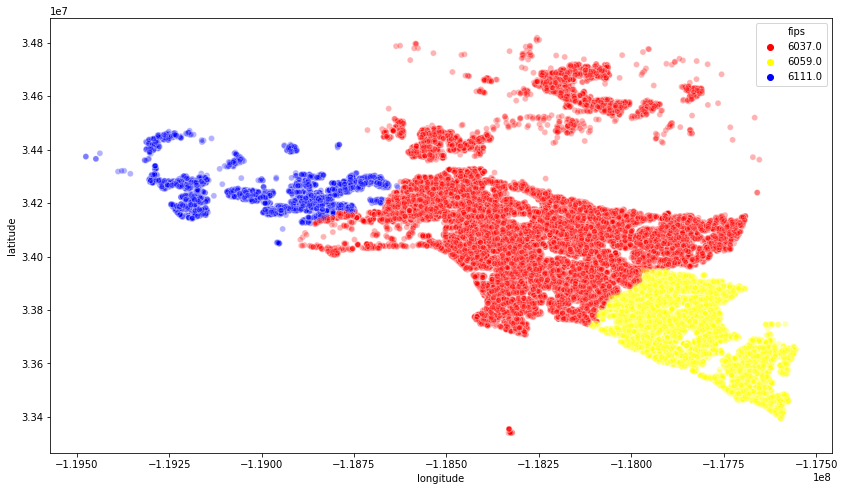

In [21]:
plt.figure(figsize=(14,8))
sns.scatterplot('longitude', 'latitude', data = df, hue = 'fips', palette=['red','yellow','blue'], alpha = .3)